In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [ ]:
# Load datasets
players_teams = pd.read_csv('../../data/initial_data/players_teams.csv')
awards = pd.read_csv('../../data/initial_data/awards_players.csv')
teams = pd.read_csv('../../data/initial_data/teams.csv')

# Aggregate Player Stints
agg_cols = ['GP', 'minutes', 'points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgMade', 'fgAttempted', 'dq']

# Sort by minutes to ensure we keep the primary team ID
players_teams = players_teams.sort_values('minutes', ascending=False)
players_agg = players_teams.groupby(['playerID', 'year'])[agg_cols].sum().reset_index()

# Get Primary Team ID for context (Win %)
primary_team_map = players_teams.drop_duplicates(subset=['playerID', 'year'])[['playerID', 'year', 'tmID']]
df = pd.merge(players_agg, primary_team_map, on=['playerID', 'year'], how='left')

# Merge Team Success Context
# Winners usually come from playoff/winning teams
df = pd.merge(df, teams[['tmID', 'year', 'won', 'lost', 'rank']], on=['tmID', 'year'], how='left')
df['team_win_pct'] = df['won'] / (df['won'] + df['lost']).replace(0, 1)

print(f"Base Dataset Shape: {df.shape}")

Base Dataset Shape: (1805, 19)


In [3]:
# Integrity Features
# "Sportsmanship is defined by what you DON'T do." - someone

# Tech/DQ Severity Index
df['dq_severity'] = df['dq'].apply(lambda x: 3 if x > 0 else 0) # Hard penalty for ejections

# The "Lady Byng" Discipline Ratio - https://en.wikipedia.org/wiki/Lady_Byng_Memorial_Trophy
df['discipline_ratio'] = df['minutes'] / (df['PF'] + (df['dq'] * 50) + 1)

# Veterancy (historically, players are more likely to win if they've been in the league for a while)
df = df.sort_values(['playerID', 'year'])
df['years_in_league'] = df.groupby('playerID').cumcount() + 1

# We aggregate All-Star selections from the awards table
all_stars = awards[awards['award'].str.contains('All-Star')].copy()
all_stars['is_all_star'] = 1
all_stars_cum = all_stars.groupby(['playerID', 'year'])['is_all_star'].sum().groupby('playerID').cumsum().reset_index()
all_stars_cum.rename(columns={'is_all_star': 'cumulative_all_stars'}, inplace=True)

df = pd.merge(df, all_stars_cum, on=['playerID', 'year'], how='left')
df['cumulative_all_stars'] = df['cumulative_all_stars'].fillna(0)

# Previous Sportsmanship Wins
sp_winners = awards[awards['award'].str.contains('Sportsmanship')].copy()
sp_winners['is_sp_winner'] = 1
sp_wins_cum = sp_winners.groupby(['playerID', 'year'])['is_sp_winner'].sum().groupby('playerID').cumsum().reset_index()
sp_wins_cum.rename(columns={'is_sp_winner': 'prev_sp_wins'}, inplace=True)
# Shift by 1 year because current year win doesn't count for prediction
sp_wins_cum['year'] += 1 

df = pd.merge(df, sp_wins_cum, on=['playerID', 'year'], how='left')
df['prev_sp_wins'] = df['prev_sp_wins'].fillna(0)

# Efficiency Proxy (PER-like)
# (Pts + Reb + Ast + Stl + Blk) - (Missed FG + TO + PF)
df['missed_fg'] = df['fgAttempted'] - df['fgMade']
df['efficiency_index'] = (
    df['points'] + df['rebounds'] + df['assists'] + df['steals'] + df['blocks']
) - (df['missed_fg'] + df['turnovers'] + df['PF'])

df['min_per_game'] = df['minutes'] / df['GP']

# Filter: Remove players with negligible impact (Source 39: "Winners are rarely role players")
df = df[df['GP'] >= 15].copy()
df = df[df['min_per_game'] >= 15].copy() 

print("Feature Engineering Complete.")

Feature Engineering Complete.


In [4]:

# Winner = 3. Everyone else = 0 (no nomitations in the dataset)
target_awards = awards[awards['award'].str.contains('Sportsmanship')]
df = pd.merge(df, target_awards[['playerID', 'year', 'award']], on=['playerID', 'year'], how='left')

df['relevance'] = df['award'].apply(lambda x: 3 if pd.notnull(x) else 0)

# Negative Downsampling (Hard Negative Mining)
# Strategy: Keep Winner + Top 20 "Hard Negatives" (High minutes/Eff) per season.

ltr_df = pd.DataFrame()

for yr in df['year'].unique():
    season_data = df[df['year'] == yr].copy()
    
    # Always keep the winner(s)
    positives = season_data[season_data['relevance'] > 0]
    
    # Select Hard Negatives
    negatives = season_data[season_data['relevance'] == 0].sort_values('efficiency_index', ascending=False).head(20)
    
    # Combine
    season_sample = pd.concat([positives, negatives])
    
    ltr_df = pd.concat([ltr_df, season_sample])

# Final Sort for LTR grouping
ltr_df = ltr_df.sort_values(by=['year', 'relevance'], ascending=[True, False])

features = [
    'discipline_ratio', 'dq_severity', 'PF',        # Integrity
    'prev_sp_wins', 'years_in_league', 'cumulative_all_stars', # Reputation
    'efficiency_index', 'team_win_pct', 'min_per_game' # Performance
]

print(f"LTR-Ready Dataset Shape: {ltr_df.shape}")
ltr_df[['year', 'playerID', 'relevance', 'discipline_ratio']].head()

LTR-Ready Dataset Shape: (210, 29)


,year,playerID,relevance,discipline_ratio
532,1,mcconsu01w,3,22.741935
825,1,swoopsh01w,0,16.029412
293,1,griffyo01w,0,6.372671
705,1,reedbr01w,0,20.566038
953,1,willina01w,0,3.778182


In [ ]:
CONFIG = {
    "objective": "rank:ndcg",        # LambdaMART Listwise Objective
    "eval_metric": "ndcg@1",         # Optimize for Top 1 position
    "tree_method": "hist",
    "learning_rate": 0.05,           # Low LR for stability
    "n_estimators": 1000,
    "max_depth": 4,                  # Shallow trees to prevent memorization
    "lambdarank_pair_method": "topk",# Focus on top of the list
    "lambdarank_num_pair_per_sample": 8,
    "early_stopping_rounds": 50,
    "test_year_start": 8             # Split for final evaluation
}

# Validation Strategy: Leave-One-Season-Out
unique_years = sorted(ltr_df['year'].unique())
metrics = []

print("--- Starting LOSO Training (LambdaMART) ---")

for test_year in unique_years:
    if test_year < 3: continue # Skip to build history
    
    # Split data
    train_data = ltr_df[ltr_df['year'] != test_year]
    test_data = ltr_df[ltr_df['year'] == test_year]
    
    if test_data['relevance'].sum() == 0: continue # Skip years with no recorded winner
    
    X_train = train_data[features]
    y_train = train_data['relevance']
    
    qids_train = train_data['year'].values
    
    X_test = test_data[features]
    y_test = test_data['relevance']
    qids_test = test_data['year'].values
    
    # Train XGBRanker
    ranker = xgb.XGBRanker(
        objective=CONFIG['objective'],
        eval_metric=CONFIG['eval_metric'],
        learning_rate=CONFIG['learning_rate'],
        n_estimators=CONFIG['n_estimators'],
        max_depth=CONFIG['max_depth'],
        lambdarank_pair_method=CONFIG['lambdarank_pair_method'],
        early_stopping_rounds=CONFIG['early_stopping_rounds'],
        random_state=42
    )
    
    ranker.fit(
        X_train, y_train,
        qid=qids_train,
        eval_set=[(X_test, y_test)],
        eval_qid=[qids_test],
        verbose=False
    )
    
    # Predict & Rank
    test_data = test_data.copy()
    test_data['score'] = ranker.predict(X_test)
    
    # Taurasi Filter
    test_data['score'] = np.where(test_data['dq_severity'] >= 3, test_data['score'] - 10, test_data['score'])
    
    # Rank by score
    test_data = test_data.sort_values('score', ascending=False)
    test_data['predicted_rank'] = np.arange(len(test_data)) + 1
    
    # Evaluate
    winner_rank = test_data[test_data['relevance'] == 3]['predicted_rank'].min()
    
    metrics.append({
        'Year': test_year,
        'Winner': test_data[test_data['relevance'] == 3]['playerID'].values[0],
        'Rank': winner_rank,
        'Top1_Hit': 1 if winner_rank == 1 else 0
    })
    
    print(f"Year {test_year}: Winner Rank = {winner_rank}")

# Summary Metrics
metrics_df = pd.DataFrame(metrics)
mrr = (1 / metrics_df['Rank']).mean()
print(f"\nMean Reciprocal Rank (MRR): {mrr:.3f}")
print(f"Top-1 Precision: {metrics_df['Top1_Hit'].mean():.1%}")

--- Starting LOSO Training (LambdaMART) ---
Year 3: Winner Rank = 1
Year 4: Winner Rank = 1
Year 5: Winner Rank = 1
Year 6: Winner Rank = 14
Year 7: Winner Rank = 1
Year 8: Winner Rank = 1
Year 9: Winner Rank = 1
Year 10: Winner Rank = 1

Mean Reciprocal Rank (MRR): 0.884
Top-1 Precision: 87.5%


<Figure size 1000x600 with 0 Axes>

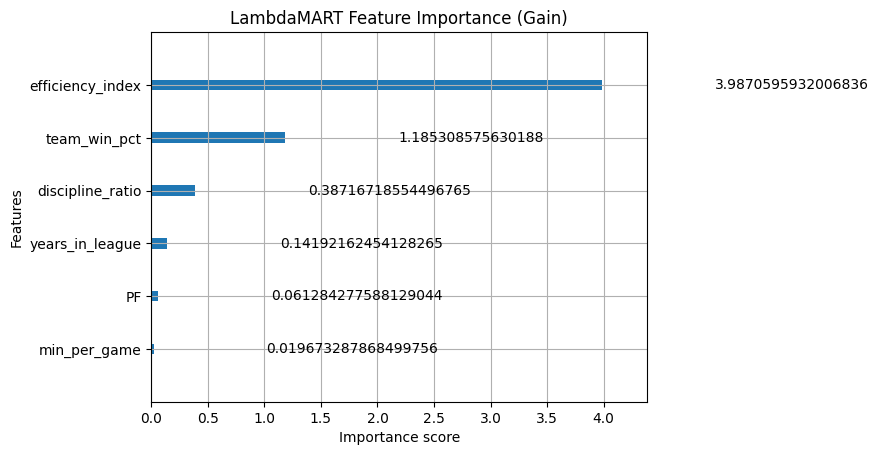

Final Pipeline Ready. To predict next season, format the new data identical to 'ltr_df' and call final_ranker.predict().


In [6]:
# Train on all data for the final test
X_all = ltr_df[features]
y_all = ltr_df['relevance']

qids_all = ltr_df['year'].values

final_ranker = xgb.XGBRanker(
    objective=CONFIG['objective'],
    eval_metric=CONFIG['eval_metric'],
    learning_rate=CONFIG['learning_rate'],
    n_estimators=CONFIG['n_estimators'],
    max_depth=CONFIG['max_depth'],
    lambdarank_pair_method=CONFIG['lambdarank_pair_method'],
    random_state=42
)

final_ranker.fit(X_all, y_all, qid=qids_all)

# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_ranker, importance_type='gain', max_num_features=10)
plt.title("LambdaMART Feature Importance (Gain)")
plt.show()

print("Final Pipeline Ready. To predict next season, format the new data identical to 'ltr_df' and call final_ranker.predict().")